In [8]:
#%matplotlib qt

## imports
import matplotlib.pyplot as plt
from matplotlib import rc
import numpy as np
import matplotlib
from matplotlib import cm
import h5py
import os
from math import pi, sqrt
from scipy.optimize import curve_fit
import scipy
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
import time
from scipy.interpolate import InterpolatedUnivariateSpline
rc('text', usetex=True)
import seaborn as sns

# Plot parameters
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
matplotlib.rcParams['axes.labelsize'] = 24
matplotlib.rcParams['xtick.labelsize'] = 30
matplotlib.rcParams['ytick.labelsize'] = 30
matplotlib.rcParams['xtick.major.size'] = 20
matplotlib.rcParams['ytick.major.size'] = 20
matplotlib.rcParams['xtick.top'] = True
matplotlib.rcParams['xtick.direction'] = 'in'
matplotlib.rcParams['xtick.minor.visible'] = True
matplotlib.rcParams['xtick.minor.size'] = 10
matplotlib.rcParams['ytick.minor.size'] = 10
matplotlib.rcParams['legend.fontsize'] = 18
matplotlib.rcParams['legend.frameon'] = True
matplotlib.rcParams['lines.linewidth'] = 3


## Read and plot GW data

In [2]:
## Data reading functions

def GetWaveformRadius(p, rad):
    psi4_file = p + 'GW2/rPsi4_FiniteRadii_CodeUnits.h5'
    f = h5py.File(psi4_file, 'r')
    radius = sorted(f.keys())[rad]
    coord_radius = f[radius]['CoordRadius.dat'][0][1]
    return coord_radius
    
def GetPsi4Mode(p, mode, radius=-1): 
    ## which finite radius should we use?
    l = mode[0]
    m = mode[1]
    psi4_file = p + 'GW2/rPsi4_FiniteRadii_CodeUnits.h5' 
    f = h5py.File(psi4_file, 'r')
    radius = sorted(f.keys())[radius]
    data = f[radius]['Y_l' + str(l) + '_m'  + str(m) + '.dat']
    time, re, im = data[:,0], data[:,1], data[:,2]
    Psi4 = re + 1j*im
    return time, Psi4

def GetStrainMode(p, mode, radius=-1): 
    ## which finite radius should we use?
    l = mode[0]
    m = mode[1]
    psi4_file = p + 'GW2/rh_FiniteRadii_CodeUnits.h5' 
    f = h5py.File(psi4_file, 'r')
    radius = sorted(f.keys())[radius]
    data = f[radius]['Y_l' + str(l) + '_m'  + str(m) + '.dat']
    time, re, im = data[:,0], data[:,1], data[:,2]
    Psi4 = re + 1j*im
    return time, Psi4

def GetPsi4ModeExtrapolated(p, mode, order=2): 
    l = mode[0]
    m = mode[1]
    psi4_file = p + 'rMPsi4_Asymptotic_GeometricUnits.h5' 
    f = h5py.File(psi4_file, 'r')
    data = f['Extrapolated_N' + str(order) +'.dir']['Y_l' + str(l) + '_m'  + str(m) + '.dat']
    time, re, im = data[:,0], data[:,1], data[:,2]
    Psi4 = re + 1j*im
    return time, Psi4

def GetStrainModeExtrapolated(p, mode, order=2): 
    l = mode[0]
    m = mode[1]
    h_file = p + 'rhOverM_Asymptotic_GeometricUnits.h5' 
    f = h5py.File(h_file, 'r')
    data = f['Extrapolated_N'+str(order)+'.dir']['Y_l' + str(l) + '_m'  + str(m) + '.dat']
    time, re, im = data[:,0], data[:,1], data[:,2]
    h = re + 1j*im
    return time, h

In [3]:
## Data helper functions

def CutTimes(time, data, TLow, TUp): ###
    TLowIndex = np.where(time >= TLow)[0][0]
    TUpIndex = np.where(time <= TUp)[0][-1]
    time = time[TLowIndex:TUpIndex]
    data = data[TLowIndex:TUpIndex]
    return time, data

def GetPeakTimeMode(time, data): ###
    ## Peak time being the peak of the magnitude of the data
    t_peak = time[np.argmax(np.absolute(data))]
    return t_peak

def GetPeakTimeModeReal(time, data): ###
    ## Peak time being the peak of the magnitude of the data
    t_peak = time[np.argmax(np.real(data))]
    return t_peak

def SubtractPeakTimeMode(time, data): ###
    t_peak = GetPeakTimeMode(time, data)
    return time - t_peak

def SubtractPeakTimeModeReal(time, data): ###
    t_peak = GetPeakTimeModeReal(time, data)
    return time - t_peak

def InterpolateTimes(time, data, time_dest):
    """ Interpolates time, data onto new time axis
        time_dest """
    interpolant = scipy.interpolate.CubicSpline(time, data)
    return interpolant(time_dest)

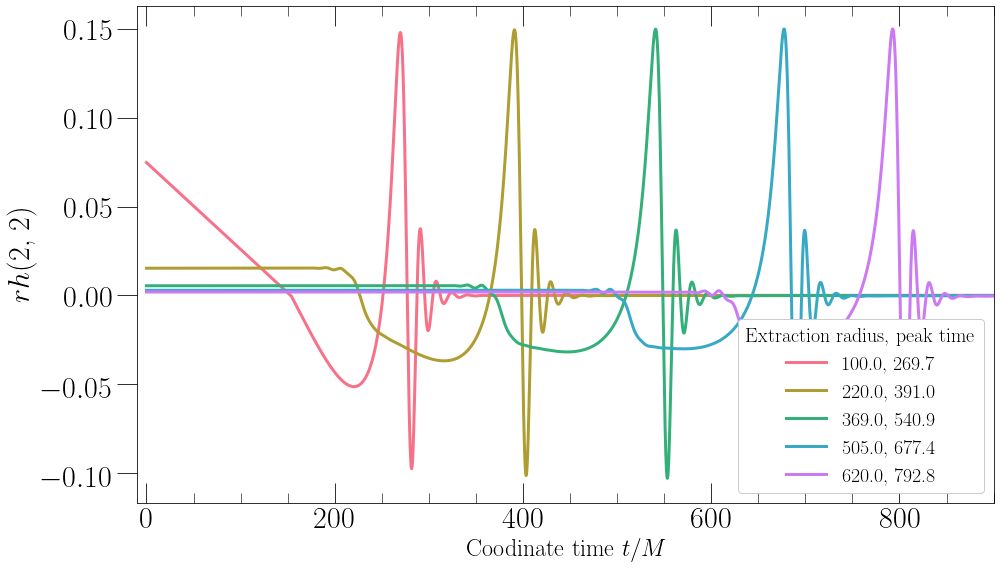

In [6]:
## Plot strain at various radii

def PlotRadiiStrain(p):
    ## Run Progress
    plt.figure(figsize=(14, 8))

    mode = (2,2)
    
    radii = [0, 15, 20, 22, 23]
    cs = sns.color_palette('husl', n_colors=len(radii))

    for rad, i in zip(radii, range(len(radii))):

        radius = int(GetWaveformRadius(p, rad))
        
        time, data = GetStrainMode(p, mode, radius=rad)
        tt = GetPeakTimeMode(time, data)
        
        plt.plot(time, np.real(data), label='%.1f, %.1f' % (radius, tt), color=cs[i])

    plt.xlabel(r'Coodinate time $t/M$')
    plt.ylabel(r'$rh$' + str(mode), fontsize=30)
    legend = plt.legend(loc='lower right', title='Extraction radius, peak time', fontsize=20, framealpha=1.0)
    plt.setp(legend.get_title(),fontsize=20)
    plt.xlim(-10, 900)
    plt.tight_layout()
    plt.savefig('RadiiPeaks.pdf')
    plt.show()
    
#PlotRadiiStrain('Data/HeadOn/JoinedLev1/')
PlotRadiiStrain('Data/HeadOn_Harmonic/JoinedLev2/')

## Plot lensing refinement method results + final positions

In [ ]:
## Plot the vanilla SpEC lensing run results

def PlotRefinementMethodResult(p):
    
    """ Print the results of the vanilla lensing run. For the file structure, we have
    Geo's final time,
    Geo's final position x,
    Geo's final position y,
    Geo's final position z,
    Geo's final 4-momentum t (roughly, redshift),
    Geo's final 4-momentum x,
    Geo's final 4-momentum y,
    Geo's final 4-momentum z"""
    
    
    file = p + '/RefinementMethodData.h5'
    f = h5py.File(file, 'r')
    data = f['GeodesicFinalVars.dat']
    
    x_positions = data[:,1]
    y_positions = data[:,2]
    z_positions = data[:,3]
    
    plt.figure(figsize=(10, 10))
    
    plt.scatter(y_positions, z_positions, color='red', s=10)
    #plt.xlim(-5.0, 5.0)
    #plt.ylim(-5.0, 5.0)

    plt.xlabel(r'Camera X')
    plt.ylabel(r'Camera Y')
    plt.tight_layout()
    plt.savefig('Camera.pdf')
    plt.show()
    
PlotRefinementMethodResult('Data/Kerr')

In [ ]:
## Plot the vanilla SpEC lensing run results

def Plot3DFinalPositions(p):
    
    """ Print the results of the vanilla lensing run. For the file structure, we have
    Geo's final time,
    Geo's final position x,
    Geo's final position y,
    Geo's final position z,
    Geo's final 4-momentum t (roughly, redshift),
    Geo's final 4-momentum x,
    Geo's final 4-momentum y,
    Geo's final 4-momentum z"""

    plt.rcParams['grid.linewidth'] = 0.25
    
    file = p + '/RefinementMethodData.h5'
    f = h5py.File(file, 'r')
    data = f['GeodesicFinalVars.dat']
    
    x_pos = data[:,1]
    y_pos = data[:,2]
    z_pos = data[:,3]
    
    fig = plt.figure(figsize=(12,12))
    ax = fig.add_subplot(111, projection='3d')
    ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
    ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
    ax.w_zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
    
    ax.scatter(x_pos, y_pos, z_pos, color='red', s=10)
    ax.scatter([0.0], [0.0], [100.0], color='black', s = 100)
    ax.quiver([0.0], [0.0], [100.0], [0.0], [0.0], [-10.0], length=20.0, normalize=True, color='black')
    
    ax.set_xlabel('Camera X',labelpad=20)
    ax.set_ylabel('Camera Y', labelpad=20)
    ax.set_zlabel('Camera Z', labelpad=20)
    plt.tight_layout()
    plt.savefig('Positions.pdf')
    plt.show()
    
Plot3DFinalPositions('Data/Kerr')


## Read in horizon data and create interpolants
## Read in geodesic trajectories

In [9]:
## Read in horizon trajectories

Lev = "2"

def read_horizon_trajectories(Horizon):
    """ Horizon is a string corresponding to the BH we're interested in [A, B, C]"""
    f = "Data/HeadOn_Harmonic/JoinedLev" + Lev + "/ApparentHorizons/Trajectory_Ah" + Horizon + ".dat"
    t, x, y, z = np.loadtxt(f, comments="#",usecols=([0,1,2,3]),unpack=True)
    return t, x, y, z

## Build the horizon interpolants
t_a, x_a, y_a, z_a = read_horizon_trajectories("A")
spl_x_a = InterpolatedUnivariateSpline(t_a, x_a)
spl_y_a = InterpolatedUnivariateSpline(t_a, y_a)
spl_z_a = InterpolatedUnivariateSpline(t_a, z_a)

t_b, x_b, y_b, z_b = read_horizon_trajectories("B")
spl_x_b = InterpolatedUnivariateSpline(t_b, x_b)
spl_y_b = InterpolatedUnivariateSpline(t_b, y_b)
spl_z_b = InterpolatedUnivariateSpline(t_b, z_b)

t_c, x_c, y_c, z_c = read_horizon_trajectories("C")
t_merger = t_b[-1]
t_ringdown = t_c[0]
spl_x_c = InterpolatedUnivariateSpline(t_c, x_c)
spl_y_c = InterpolatedUnivariateSpline(t_c, y_c)
spl_z_c = InterpolatedUnivariateSpline(t_c, z_c)

def horizon_at_time(time, Horizon):
    if Horizon == "A":
        return spl_x_a(time), spl_y_a(time), spl_z_a(time)
    if Horizon == "B":
        return spl_x_b(time), spl_y_b(time), spl_z_b(time)
    if Horizon == "C":
        return spl_x_c(time), spl_y_c(time), spl_z_c(time)
    else:
        print("Unrecognized horizon argument")

def min_distance_to_horizon(t, x, y, z):
    """ Returns the minimum distance of a geodesic to a horizon over all time
        t, x, y, z are arrays with the history of the geodesic"""
    min_distance = 1e10
    
    def distance_sqr(xx, yy, zz, xx_h, yy_h, zz_h):
        return (xx - xx_h)**2 + (yy - yy_h)**2 + (zz - zz_h)**2
    
    def distance_to_horizon(time, xx, yy, zz):
        """ Returns the minimum distance to the relevant horizon at given time"""
        min_dist = 1e10
        ## look at AhA and AhB before merger
        if time <= t_merger:
            for horizon in ["A", "B"]:
                xx_h, yy_h, zz_h = horizon_at_time(time, horizon)
                dist = distance_sqr(xx, yy, zz, xx_h, xx_h, xx_h)
                min_dist = min(min_dist, dist)
        ## look at AhC after ringdown
        elif time > t_ringdown:
            xx_h, yy_h, zz_h = horizon_at_time(time, "C")
            dist = distance_sqr(xx, yy, zz, xx_h, xx_h, xx_h)
            min_dist = min(min_dist, dist)
        return min_dist
                
    ## minimize over the times
    for time, xx, yy, zz in zip(t, x, y, z):
        
        dist_horizon = distance_to_horizon(time, xx, yy, zz)
        min_distance = min(min_distance, dist_horizon)
        #print(time, min_distance)
        
    return(sqrt(min_distance))
            

In [10]:
## Functions for reading geodesic positions over time from NodeX.h5 files

def read_geodesic_data(p):
    """ Read in an array of times and positions for all geodesics at once"""
        
    file = p + '/Node0.h5'
    f = h5py.File(file, 'r')
    ## grab the .dat files
    keys = [k for k in f.keys() if 'dat' in k]
    ## Array of times from the .dat files
    times = [float(k.split('.dat')[0]) for k in keys]
    ## sort keys according to times
    times, keys = zip(*sorted(zip(times, keys)))
    times = times[::-1]
    keys = keys[::-1]
    ## grab the number of geodesics
    N_geodesics = len(f[keys[0]][:,0])
    print("Total geodesics: ", N_geodesics, "Time steps: ", len(times))
    ## Minimum index
    m = int(f[keys[0]][:,0][0])
    print("Minimum index of this refinement iteration: ", m)
    
    X = [ [] for _ in range(N_geodesics)]
    Y = [ [] for _ in range(N_geodesics)]
    Z = [ [] for _ in range(N_geodesics)]
    T = [ [] for _ in range(N_geodesics)]
    
    for k, t in zip(keys, times):
        data = f[k]
        ## indices and positions for all geodesics at this time
        indices = data[:,0]
        x = data[:,5]
        y = data[:,6]
        z = data[:,7]
        ## fill in the array for each index
        for i, j in zip(indices.astype(int), range(len(indices))):
            X[i-1-m] = np.append(X[i-1-m], x[j])
            Y[i-1-m] = np.append(Y[i-1-m], y[j])
            Z[i-1-m] = np.append(Z[i-1-m], z[j])
            T[i-1-m] = np.append(T[i-1-m], t)
            
    return T, X, Y, Z

def grab_geodesic_data(a, T, X, Y, Z):

    x = X[a]
    y = Y[a]
    z = Z[a]
    t = T[a]
    return t, x, y, z

In [11]:
## Functions for reading GetTrajectoriesFromH5 output
def ReadGetTrajectoriesFromH5(p, n):
    """ Read in the post-processed trajectory for the nth geodesic """
    f = p + '/Trajectories/' + str(n) + '.dat'
    t, x, y, z = np.loadtxt(f, comments="#",usecols=([0,5,6,7]),unpack=True)
    return t, x, y, z

def ReadRedshiftGetTrajectoriesFromH5(p, n):
    """ Read in the post-processed trajectory for the nth geodesic, 
        also output the redshift """
    f = p + '/Trajectories/' + str(n) + '.dat'
    t, p0, x, y, z = np.loadtxt(f, comments="#",usecols=([0,1,5,6,7]),unpack=True)
    return t, p0, x, y, z

## Plot geodesic trajectories and redshifts

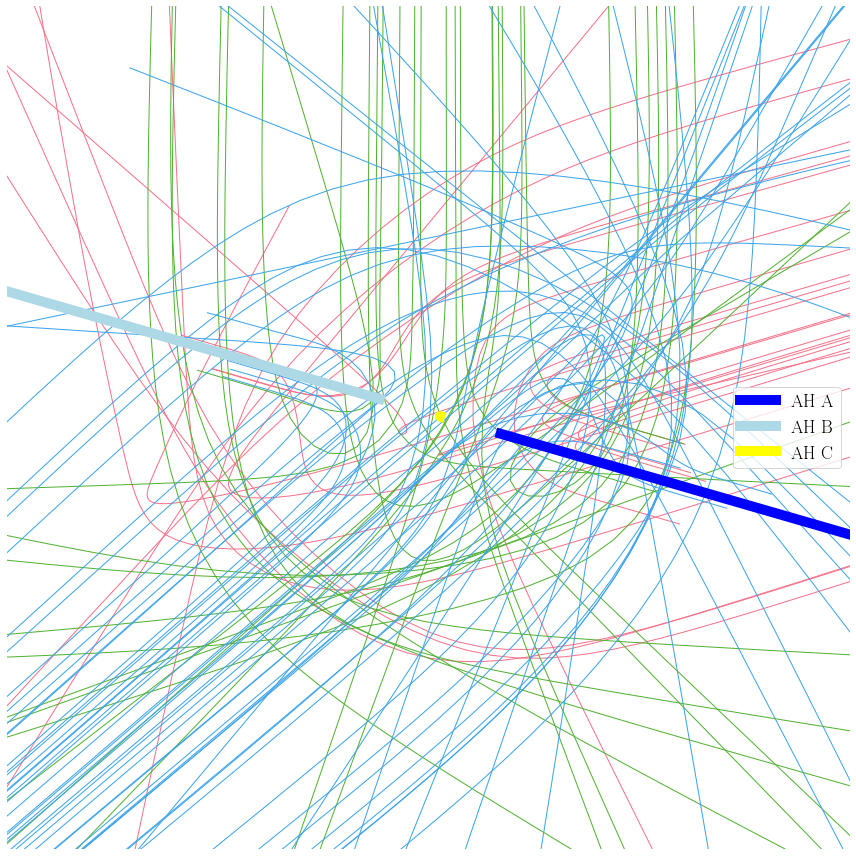

In [40]:
## Plot the trajectories obtained from the GetTrajectoriesFromH5 executable
def PlotGetTrajectoriesFromH5(p_arr, figname):
    
    def plot_trajectories_file(p, color):
        for n in np.arange(0, 1000, 1):
            t, p0, x, y, z = ReadRedshiftGetTrajectoriesFromH5(p, n)
            horizon_dist = min_distance_to_horizon(t, x, y, z)
            if (horizon_dist < 3):
                ax.plot(x, y, z, lw=1.0, color=color)
     
    fig = plt.figure(figsize=(12,12))
    ax = fig.add_subplot(111, projection='3d')
    
    cs = sns.color_palette('husl', n_colors=len(p_arr))
    for p, i in zip(p_arr, range(len(p_arr))):
        plot_trajectories_file(p, cs[i])
        
    ## Add in the horizons
    for horizon, color in zip(["A", "B", "C"], ["blue", "lightblue", "yellow"]):
        t_h, x_h, y_h, z_h = read_horizon_trajectories(horizon)
        plt.plot(x_h, y_h, z_h, label="AH " + horizon, color=color, lw = 10.0)
        
    #ax.scatter([0.0], [0.0], [0.0], color='red', s =100, marker='+')
    ax.set_xlabel('Camera X',labelpad=20)
    ax.set_ylabel('Camera Y', labelpad=20)
    ax.set_zlabel('Camera Z', labelpad=20)
    lim = 5
    ax.set_xlim(-lim, lim)
    ax.set_ylim(-lim, lim)
    ax.set_zlim(-lim, lim)
    ax.set_axis_off()
    
    plt.legend()
    plt.tight_layout()
    plt.savefig('Histories_' + figname + '.pdf')
    plt.show()
    

PlotGetTrajectoriesFromH5(['Data/TraceHeadOn_86_0_50/', 'Data/TraceHeadOn_0_0_100/', \
                           'Data/TraceHeadOn_-43_-74_-49'], '3Camera')
#PlotGetTrajectoriesFromH5(['Data/TraceHeadOn_0_0_100'], 'Focused')

In [ ]:
## Plot redshift with time
def PlotRedshiftsGetTrajectoriesFromH5Time(p, figname):
     
    fig = plt.figure(figsize=(12,12))
    #ax = fig.add_subplot(111, projection='3d')
    
    redshifts = []
    rmins = []
    for n in np.arange(0, 1000, 1):
        t, p0, x, y, z = ReadRedshiftGetTrajectoriesFromH5(p, n)
        r2min = min(x**2 + y**2 + z**2)
        t = t - 269.7
        plt.plot(t, p0, color='black', lw=0.5)
    
    plt.scatter(rmins, redshifts)
    plt.xlabel('Time (geodesics going backwards in time)')
    plt.ylabel('Maximum $p_0$ (column [1] the .dat file)')
    plt.tight_layout()
    plt.savefig('Redshifts_' + figname + '.pdf')
    plt.yscale('log')
    plt.show()
    
    
PlotRedshiftsGetTrajectoriesFromH5Time('Data/HeadOn_50/', 'HeadOn_50')

In [ ]:
## Plot redshift versus min radius 
def PlotRedshiftsGetTrajectoriesFromH5(p, figname):
     
    fig = plt.figure(figsize=(8,5))
    #ax = fig.add_subplot(111, projection='3d')
    
    redshifts = []
    rmins = []
    for n in np.arange(0, 1000, 1):
        t, p0, x, y, z = ReadRedshiftGetTrajectoriesFromH5(p, n)
        r2min = min(x**2 + y**2 + z**2)
        if (r2min < 100):
            redshifts.append(max(p0))
            rmins.append(sqrt(r2min))
        #t = t - 269.7
        #plt.plot(t, p0, color='black', lw=0.5)
    
    plt.scatter(rmins, redshifts, color='black')
    plt.xlabel('Minimum radius')
    plt.ylabel('Maximum $p_0$')
    plt.tight_layout()
    plt.savefig('Redshifts_' + figname + '.pdf')
    plt.yscale('log')
    plt.show()
    
    
PlotRedshiftsGetTrajectoriesFromH5('Data/HeadOn_50/', 'HeadOn_50')

## Isotropic sphere distribution

No handles with labels found to put in legend.


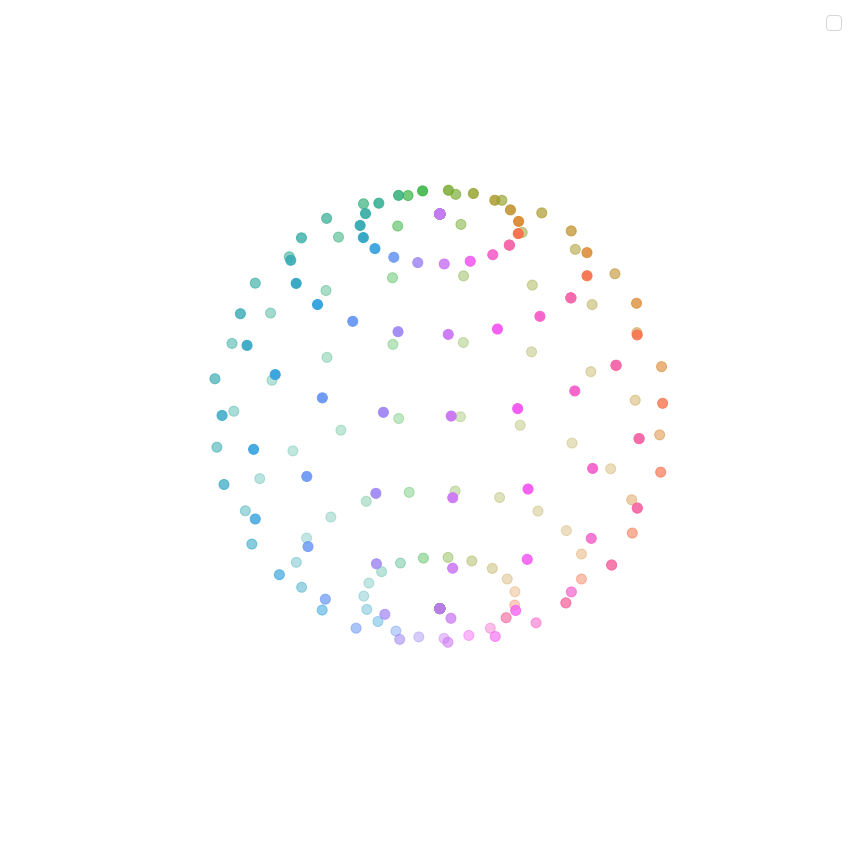

In [56]:
def SpherePlot():
    
    fig = plt.figure(figsize=(12,12))
    ax = fig.add_subplot(111, projection='3d')
    
    ## Sphere radius
    R = 100
    
    ## Plot mesh sphere
    u, v = np.mgrid[0:2*np.pi:100j, 0:np.pi:100j]
    x = R*np.cos(u)*np.sin(v)
    y = R*np.sin(u)*np.sin(v)
    z = R*np.cos(v)
    #ax.plot_wireframe(x, y, z, color="blue", linewidth=0.1)
    
    
    ## Camera coordinates
    theta_points = 10
    phi_points = 20
    
    cs = sns.color_palette('husl', n_colors=phi_points)
    for u, i in zip(np.linspace(0, 2*pi, phi_points), range(phi_points)):
        x = []
        y = []
        z = []
        for v in np.linspace(0, pi, theta_points):
            x.append(R*np.cos(u)*np.sin(v))
            y.append(R*np.sin(u)*np.sin(v))
            z.append(R*np.cos(v))
            #print(int(R*np.cos(u)*np.sin(v)), int(R*np.sin(u)*np.sin(v)), int(R*np.cos(v)))
        ax.scatter(x, y, z, s=100, color=cs[i])
            
            
        
    #u, v = np.mgrid[0:2*np.pi:points, 0:np.pi:points]
    #x = R*np.cos(u)*np.sin(v)
    #y = R*np.sin(u)*np.sin(v)
    #z = R*np.cos(v)
    
    #ax.plot_wireframe(x, y, z, color="b", linewidth=0.1)
    
    
    ax.set_xlabel('Camera X',labelpad=20)
    ax.set_ylabel('Camera Y', labelpad=20)
    ax.set_zlabel('Camera Z', labelpad=20)
    ax.set_axis_off()
    lim = 100
    ax.set_xlim(-lim, lim)
    ax.set_ylim(-lim, lim)
    ax.set_zlim(-lim, lim)
    
    plt.legend()
    plt.tight_layout()
    plt.savefig('Sphere.pdf')
    plt.show()

SpherePlot()